## Coleta de dados

### Dependências

In [ ]:
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

!pip install cloudscraper --quiet
!pip install selenium --quiet

import json
import re
import time

from bs4 import BeautifulSoup
from google.colab import files
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import cloudscraper
import pandas as pd

options = webdriver.ChromeOptions()
options.add_argument('-headless')
options.add_argument('-no-sandbox')
options.add_argument('-disable-dev-shm-usage')

driver = webdriver.Chrome('chromedriver', options=options)

scraper = cloudscraper.create_scraper()

     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 61kB 4.4MB/s 


### Web scraping vivareal.com.br

In [ ]:
BASE_URL = 'https://www.vivareal.com.br/venda/santa-catarina/florianopolis'

vr_endpoint_fpolis = BASE_URL + '/{}/'

vr_dict = {
  'tipo': [],
  'bairro': [],
  'área (m2)': [],
  'quartos': [],
  'banheiros': [],
  'vagas de garagem': [],
  'preço': []
}

for req_type in (
  'condominio_residencial',
  'cobertura_residencial', 
  'apartamento_residencial', 
  'casa_residencial'
):
  print(req_type)
  driver.get(vr_endpoint_fpolis.format(req_type))

  pg, last_page = 1, False
  while (not last_page):
    vr_listing_soup = BeautifulSoup(driver.page_source, 'html.parser')

    listings = vr_listing_soup.find_all('article', class_='js-property-card')
    for listing in listings:
      # ignorar imóveis na planta ou em construção
      if listing.find('div', class_='js-construction-status'):
        continue

      type_ = ''
      if req_type == 'apartamento_residencial':
        type_ = 'Apartamento'
      elif req_type == 'cobertura_residencial':
        type_ = 'Cobertura'
      elif req_type == 'casa_residencial':
        type_ = 'Casa'
      elif req_type == 'condominio_residencial':
        type_ = 'Casa de condomínio'
      
      neighborhood_str = listing.find('span', class_='property-card__address').string.strip()
      if ', Florianópolis - SC' not in neighborhood_str:
        continue

      if neighborhood_str.count('-') == 2:
        neighborhood = re.search(r'- (.+), Florianópolis - SC', neighborhood_str).group(1)
      else:
        neighborhood = re.search(r'^(.+), Florianópolis - SC', neighborhood_str).group(1)

      area = None
      area_tag = listing.find('li', class_='property-card__detail-area')
      if area_tag:
        area = area_tag.find('span', class_='property-card__detail-value').string.strip()
      
      bedrooms = None
      bedrooms_tag = listing.find('li', class_='property-card__detail-room')
      if bedrooms_tag:
        bedrooms = bedrooms_tag.find('span', class_='property-card__detail-value').string.strip()
      
      bathrooms = None
      bathrooms_tag = listing.find('li', class_='property-card__detail-bathroom')
      if bathrooms_tag:
        bathrooms = bathrooms_tag.find('span', class_='property-card__detail-value').string.strip()
      
      parking_spaces = None
      parking_spaces_tag = listing.find('li', class_='property-card__detail-garage')
      if parking_spaces_tag:
        parking_spaces = parking_spaces_tag.find('span', class_='property-card__detail-value').string.strip()
      
      price_tag = listing.find('div', class_='js-property-card-prices').find('p', style='display: block;')
      if price_tag is None:
        continue
      price = price_tag.string.strip()
      
      vr_dict['tipo'].append(type_)
      vr_dict['bairro'].append(neighborhood)
      vr_dict['área (m2)'].append(area)
      vr_dict['quartos'].append(bedrooms)
      vr_dict['banheiros'].append(bathrooms)
      vr_dict['vagas de garagem'].append(parking_spaces)
      vr_dict['preço'].append(re.sub(r'\D', '', price))

    print('pg {} ok'.format(pg))

    try:
      next_page_btn = driver.find_element_by_xpath("//a[@class='js-change-page'][@title='Próxima página']")
      next_page_btn.click()
    except:
      print('não há mais páginas de {}'.format(req_type))
      last_page = True
    finally:
      time.sleep(5)
    
    pg += 1

vr_df = pd.DataFrame(vr_dict)
vr_df.to_csv('/content/vivareal.tsv', sep='\t', index=False)
files.download('/content/vivareal.tsv')

### Web scraping imovelweb.com.br

In [ ]:
BASE_URL = 'https://www.imovelweb.com.br'

iw_endpoint_fpolis = BASE_URL + '/{}-venda-florianopolis-sc-pagina-{}.html'

iw_dict = {
  'tipo': [],
  'bairro': [],
  'área (m2)': [],
  'quartos': [],
  'banheiros': [],
  'vagas de garagem': [],
  'preço': []
}

for req_type in ('apartamentos', 'casas'):
  print(req_type)

  pg, last_page, results, count = 1, False, None, 0
  while (not last_page):
    iw_listing_res = scraper.get(iw_endpoint_fpolis.format(req_type, pg))

    iw_listing_soup = BeautifulSoup(iw_listing_res.content, 'html.parser')

    if results is None:
      results_str = iw_listing_soup.find('h1', class_='list-result-title').string
      results = int(re.sub(r'\D', '', results_str))

    for listing in iw_listing_soup.find_all('div', class_='postingCard'):
      count += 1

      # ignorar imóveis na planta ou em construção
      if (
        listing.find('span', class_='fromPrice') or
        listing.find('i', class_='iconUnits')
      ):
        continue
      
      description = listing.find('div', class_='postingCardDescription').text.strip()
      
      if req_type == 'apartamentos':
        if 'cobertura ' in description.lower():
          type_ = 'Cobertura'
        else:
          type_ = 'Apartamento'
      elif req_type == 'casas':
        type_ = 'Casa'
        condominium_tag = listing.find('span', class_='postingCardExpenses')
        if condominium_tag:
          if condominium_tag.string:
            if 'condomínio' in condominium_tag.string.lower():
              type_ = type_ + ' de condomínio'
      
      iw_dict['tipo'].append(type_)

      neighborhood = listing.find('span', class_='postingCardLocation').span.text.strip().split(',')[0]
      iw_dict['bairro'].append(neighborhood)

      area = None
      area_tag = listing.find('i', class_=['iconArea'])
      if area_tag:
        area = [s for s in area_tag.parent.stripped_strings][0]
        area = re.search(r'(\d+)\D+', area).group(1)
      iw_dict['área (m2)'].append(area)

      bedrooms = None
      bedrooms_tag = listing.find('i', class_='iconBedrooms')
      if bedrooms_tag:
        bedrooms = [s for s in bedrooms_tag.parent.stripped_strings][0]
        bedrooms = re.search(r'(\d+)\D+', bedrooms).group(1)
      iw_dict['quartos'].append(bedrooms)

      bathrooms = None
      bathrooms_tag = listing.find('i', class_='iconBathrooms')
      if bathrooms_tag:
        bathrooms = [s for s in bathrooms_tag.parent.stripped_strings][0]
        bathrooms = re.search(r'(\d+)\D+', bathrooms).group(1)
      iw_dict['banheiros'].append(bathrooms)
      

      parking_spaces = None
      parking_spaces_tag = listing.find('i', class_='iconGarage')
      if parking_spaces_tag:
        parking_spaces = [s for s in parking_spaces_tag.parent.stripped_strings][0]
        parking_spaces = re.search(r'(\d+)\D+', parking_spaces).group(1)
      iw_dict['vagas de garagem'].append(parking_spaces)

      price = listing.find('span', class_='firstPrice').text.strip()
      iw_dict['preço'].append(re.sub(r'\D', '', price))

    print('pg {} ok'.format(pg))
    time.sleep(2)
    pg += 1

    if count >= results:
      last_page = True
    
    print('count', count, 'results', results)

iw_df = pd.DataFrame(iw_dict)
iw_df.to_csv('/content/imovelweb.tsv', sep='\t', index=False)
files.download('/content/imovelweb.tsv')

## Tratamento de Dados

In [ ]:
!pip install impyute --quiet

from google.colab import files
from impyute.imputation.cs import mice
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# Carregamento

vr_df = pd.read_csv('/content/vivareal.tsv', sep='\t', dtype={
  'tipo': 'string',
  'bairro': 'string',
  'área (m2)': 'float',
  'quartos': 'float',
  'banheiros': 'float',
  'vagas de garagem': 'float',
  'preço': 'float'
})

vr_df_start_len = len(vr_df)
print('vivareal - registros: ', vr_df_start_len)

iw_df = pd.read_csv('/content/imovelweb.tsv', sep='\t', dtype={
  'tipo': 'string',
  'bairro': 'string',
  'área (m2)': 'float',
  'quartos': 'float',
  'banheiros': 'float',
  'vagas de garagem': 'float',
  'preço': 'float'
})

iw_df_start_len = len(iw_df)
print('imovelweb - registros: ', iw_df_start_len)

# Concatenação

df = pd.concat([vr_df, iw_df])
df_start_len = len(df)
print('total registros: ', df_start_len)

# Remoção de registros duplicados

df = df.drop_duplicates(ignore_index=True)
print('registros duplicados: ', df_start_len - len(df))

# Contagens das ausências

a_columns = ['Atributo', 'Ausências']
a_rows = []

for c in df.columns:
  a_rows.append([c, df[c].isna().sum()])

a_df = pd.DataFrame(a_rows, columns=a_columns)
display(a_df)

# Registros com quartos ausente

df = df[~df['quartos'].isna()]

# Registros com vagas de garagem ausente

df['vagas de garagem'] = df['vagas de garagem'].fillna(0)

# Registros com área (m2) ausente

display(sns.displot(
  data=np.log(df['área (m2)'], where=(df['área (m2)'] != 0)), kde=True)
)

imputed = mice(df[['área (m2)', 'quartos', 'banheiros', 'vagas de garagem']].values)
mice_area = imputed[:, 0]
df['área (m2)'] = np.around(np.abs(mice_area))

display(sns.displot(
  data=np.log(df['área (m2)'], where=(df['área (m2)'] != 0)), kde=True)
)

# Registros com banheiros ausente

display(sns.displot(
  data=np.log(df['banheiros'], where=(df['banheiros'] != 0)), kde=True)
)

imputed = mice(df[['banheiros', 'área (m2)', 'quartos', 'vagas de garagem']].values)
mice_bathroom = imputed[:, 0]
df['banheiros'] = np.around(np.abs(mice_bathroom))

display(sns.displot(
  data=np.log(df['banheiros'], where=(df['banheiros'] != 0)), kde=True)
)

# Inspeção de possíveis variações nos nomes dos bairros

neighborhoods = set()
for idx, neighborhood in df['bairro'].items():
  neighborhoods.add(neighborhood)
print(sorted(neighborhoods))

def fix_var_neighborhood(neighborhood):
  global var_count

  if neighborhood in (
    'Alto Ribeirão Leste'
  ):
    var_count += 1
    return 'Alto Ribeirão'

  if neighborhood in (
    'Armacao do Pântano do Sul', 
    'Armação', 
    'Armação do Pântano do Sul'
  ):
    var_count += 1
    return 'Pântano do Sul'

  if neighborhood in (
    'Avenida do Ipê-Amarelo - Lagoa da Conceição', 
    'Avenida do Ipê-Amarelo, 333 - Lagoa da Conceição',
    'Rua do Beija-Flor - Lagoa da Conceição', 
    'Rua do Beija-Flor, 219 - Lagoa da Conceição', 
    'Rua do Bem-Te-Vi - Lagoa da Conceição', 
    'Rua do Bem-Te-Vi, 100 - Lagoa da Conceição', 
    'Rua do Ipê-Roxo - Lagoa da Conceição', 
    'Rua do Ipê-Roxo, 305 - Lagoa da Conceição', 
    'Rua do Ipê-Roxo, 50 - Lagoa da Conceição'
  ):
    var_count += 1
    return 'Lagoa da Conceição'

  if neighborhood in (
    'Balneario', 
    'Balneário'
  ):
    var_count += 1
    return 'Estreito'

  if neighborhood in (
    'Servidão Jacatirão-Açu - Campeche', 'Servidão Jacatirão-Açu, 101 - Campeche',
    'Campeche Central', 
    'Campeche Leste', 
    'Servidão Araçá-da-Praia - Campeche'
  ):
    var_count += 1
    return 'Campeche'

  if neighborhood in (
    'Jurere Leste' 
  ):
    var_count += 1
    return 'Jurerê'

  if neighborhood in (
    'P das Canas',
    'Ponta das  Canas'
  ):
    var_count += 1
    return 'Ponta das Canas'

  if neighborhood in (
    'Praia Acores'
  ):
    var_count += 1
    return 'Praia dos Açores'

  if neighborhood in (
    'Rua Arco-Íris - Carianos', 
    'Rua Arco-Íris, 172 - Carianos', 
    'Rua Arco-Íris, 61 - Carianos'
  ):
    var_count += 1
    return 'Carianos'

  if neighborhood in (
    'Rua Maestro Villa-Lobos - João Paulo'
  ):
    var_count += 1
    return 'João Paulo'

  if neighborhood in (
    'Rua Bem-Te-Vi - Ingleses do Rio Vermelho', 
    'Rua Bem-Te-Vi, 1050 - Ingleses do Rio Vermelho', 
    'Rua Tico-Tico, 338 - Ingleses do Rio Vermelho',
    'Rua do Trinta - Réis - Ingleses do Rio Vermelho', 
    'Rua do Trinta - Réis, 64 - Ingleses do Rio Vermelho'
  ):
    var_count += 1
    return 'Ingleses do Rio Vermelho'

  if neighborhood in (
    'Rua dos Lambari-Guaçu - Jurerê Internacional', 
    'Rua dos Lambari-Guaçu, 112 - Jurerê Internacional', 
    'Rua dos Lambari-Guaçu, 397 - Jurerê Internacional', 
    'Rua dos Lambari-Guaçu, 400 - Jurerê Internacional', 
    'Rua dos Lambari-Guaçu, 417 - Jurerê Internacional', 
    'Rua dos Peixes-Elétricos - Jurerê Internacional', 
    'Rua dos Peixes-Espada - Jurerê Internacional', 
    'Rua dos Peixes-Espada, 49 - Jurerê Internacional', 
    'Rua dos Peixes-Lua - Jurerê', 
    'Rua dos Peixes-Lua - Jurerê Internacional', 
    'Rua dos Peixes-Lua, 121 - Jurerê Internacional', 
    'Rua dos Peixes-Lua, 4 - Jurerê', 
    'Rua dos Peixes-Lua, 49 - Jurerê Internacional', 
    'Rua dos Peixes-Lua, 70 - Jurerê Internacional', 
    'Rua dos Peixes-Serra - Jurerê Internacional', 
    'Rua dos Peixes-Serra, 103 - Jurerê Internacional', 
    'Rua dos Peixes-Serra, 133 - Jurerê Internacional'
  ):
    var_count += 1
    return 'Jurerê Internacional'

  if neighborhood in (
    'Jd Anchieta'
  ):
    var_count += 1
    return 'Jardim Anchieta'

  if neighborhood in (
    'ingleses',
    'Ingleses Sul',
    'Rua do Trinta - Réis, 102 - Ingleses Sul',
    'Ingleses Centro', 'Ingleses Norte'
  ):
    var_count += 1
    return 'Ingleses'

  if neighborhood in (
    'SC-405 - Moenda'
  ):
    var_count += 1
    return 'Moenda'

  if neighborhood in (
    'Tapera da Base'
  ):
    var_count += 1
    return 'Tapera'

  if neighborhood in (
    'Servidão Ipê-Branco, 350 - São João do Rio Vermelho',
    'Rio Vermelho'
  ):
    var_count += 1
    return 'São João do Rio Vermelho'

  if neighborhood in (
    'Santa Monica'
  ):
    var_count += 1
    return 'Santa Mônica'

  if neighborhood in (
    'Santo Antonio de Lisboa'
  ):
    var_count += 1
    return 'Santo Antônio de Lisboa'

  return neighborhood

var_count = 0
df['bairro'] = df.apply(lambda row: fix_var_neighborhood(row['bairro']), axis=1)
print('variações encontradas: ', var_count)

neighborhoods = set()
for idx, neighborhood in df['bairro'].items():
  neighborhoods.add(neighborhood)
print(sorted(neighborhoods))

# Exportação

df.to_csv('/content/dataset.tsv', sep='\t', index=False)
files.download('/content/dataset.tsv')

vivareal - registros:  26444
imovelweb - registros:  29128
total registros:  55572
registros duplicados:  12502


,Atributo,Ausências
0,tipo,0
1,bairro,0
2,área (m2),223
3,quartos,1
4,banheiros,1491
5,vagas de garagem,2064
6,preço,0


['Abraão', 'Agronômica', 'Alto Ribeirão', 'Alto Ribeirão Leste', 'Armacao do Pântano do Sul', 'Armação', 'Armação do Pântano do Sul', 'Autódromo', 'Avenida do Ipê-Amarelo - Lagoa da Conceição', 'Avenida do Ipê-Amarelo, 333 - Lagoa da Conceição', 'Balneario', 'Balneário', 'Barra da Lagoa', 'Barreiros', 'Beira Mar Norte', 'Bom Abrigo', 'Cachoeira do Bom Jesus', 'Cacupé', 'Caiacanga', 'Campeche', 'Campeche Central', 'Campeche Leste', 'Campinas', 'Canajurê', 'Canasvieiras', 'Canto', 'Canto da Lagoa', 'Canto dos Araçás', 'Capoeiras', 'Carianos', 'Carvoeira', 'Centro', 'Coloninha', 'Coqueiros', 'Costa da Lagoa', 'Costeira Do Ribeirao Da Ilha', 'Costeira do Pirajubaé', 'Costeira do Ribeirão', 'Córrego Grande', 'Daniela', 'Estreito', 'Ingleses', 'Ingleses Centro', 'Ingleses Norte', 'Ingleses Sul', 'Ingleses do Rio Vermelho', 'Itacorubi', 'Itaguaçu', 'Jardim Anchieta', 'Jardim Atlântico', 'Jd Anchieta', 'José Mendes', 'João Paulo', 'Jurere Leste', 'Jurerê', 'Jurerê Internacional', 'Lagoa Pequen

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Análise e Exploração dos Dados

### Dependências

In [ ]:
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import seaborn as sns

### Estatística Descritiva

In [ ]:
import pandas as pd

df = pd.read_csv('/content/dataset.tsv', sep='\t')
df['count'] = df.index + 1

print(df.info())

sts_columns = ['Atributo', 'Mín.', 'Máx.', 'μ', 'M', 'σ']
sts_rows = []

for c in df.columns:
  if c in ('count', 'tipo', 'bairro'):
    continue
  
  sts_rows.append([
    c, 
    round(df[c].min(), 2),
    round(df[c].max(), 2),
    round(df[c].mean(), 2),
    round(df[c].median(), 2),
    round(df[c].std(), 2)
  ])

sts_df = pd.DataFrame(sts_rows, columns=sts_columns)
display(sts_df)

df['tipo'] = df['tipo'].astype('category')
df['bairro'] = df['bairro'].astype('category')

df_pivot = pd.pivot_table(df, index=['tipo'], aggfunc={'preço': 'mean', 'count': 'count'})
display(df_pivot.sort_values(by='preço', ascending=False))

df_pivot = pd.pivot_table(df, index=['bairro'], aggfunc={'preço': 'mean'})
display(df_pivot.sort_values(by='preço', ascending=False).head(10))

df_pivot = pd.pivot_table(df, index=['bairro'], aggfunc={'count': 'count'})
display(df_pivot.sort_values(by='count', ascending=False).head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43069 entries, 0 to 43068
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tipo              43069 non-null  object 
 1   bairro            43069 non-null  object 
 2   área (m2)         43069 non-null  float64
 3   quartos           43069 non-null  float64
 4   banheiros         43069 non-null  float64
 5   vagas de garagem  43069 non-null  float64
 6   preço             43069 non-null  float64
 7   count             43069 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 2.6+ MB
None


,Atributo,Mín.,Máx.,μ,M,σ
0,área (m2),0.0,482190.0,311.34,153.0,5014.56
1,quartos,1.0,34.0,3.01,3.0,1.23
2,banheiros,1.0,25800.0,3.37,2.0,124.32
3,vagas de garagem,0.0,1011.0,2.21,2.0,8.52
4,preço,15000.0,37000000.0,1306005.64,800000.0,1693048.68


,count,preço
tipo,,
Casa de condomínio,2465,2.428250e+06
Casa,13603,1.632653e+06
Cobertura,6347,1.599763e+06
Apartamento,20654,8.666626e+05


,preço
bairro,
Cacupé,4.232265e+06
Jurerê Internacional,4.165743e+06
Beira Mar Norte,3.630729e+06
Lagoa da Conceição,1.942360e+06
João Paulo,1.940053e+06
Porto da Lagoa,1.939506e+06
Praia da Lagoinha,1.835714e+06
Jardim Anchieta,1.833739e+06
Agronômica,1.802626e+06


,count
bairro,
Ingleses do Rio Vermelho,6165
Centro,4242
Jurerê Internacional,2545
Campeche,2373
Itacorubi,2324
Ingleses,1982
Jurerê,1721
Agronômica,1563
Canasvieiras,1553


### Outliers

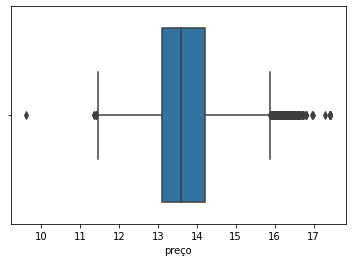

In [ ]:
display(sns.boxplot(
  x=np.log(df['área (m2)'], where=(df['área (m2)'] != 0)))
)

display(sns.boxplot(
  x=np.log(df['quartos'], where=(df['quartos'] != 0)))
)

display(sns.boxplot(
  x=np.log(df['banheiros'], where=(df['banheiros'] != 0)))
)

display(sns.boxplot(
  x=np.log(df['vagas de garagem'], where=(df['vagas de garagem'] != 0)))
)

display(sns.boxplot(
  x=np.log(df['preço'], where=(df['preço'] != 0)))
)

### Testes de Hipóteses

normaltest k2:  52439.848540603394
normaltest p 0.0
KruskalResult(statistic=65797.17114125079, pvalue=0.0)
KruskalResult(statistic=64642.477887709996, pvalue=0.0)


spearman área SpearmanrResult(correlation=0.719405392943521, pvalue=0.0)
spearman quartos SpearmanrResult(correlation=0.6166411534532618, pvalue=0.0)
spearman banheiros SpearmanrResult(correlation=0.6240803084903698, pvalue=0.0)
spearman vagas de garagem SpearmanrResult(correlation=0.6025429965268443, pvalue=0.0)


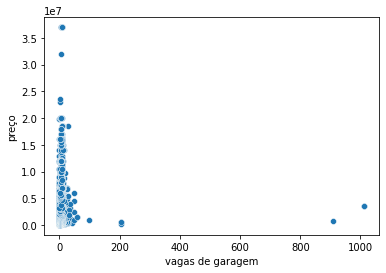

In [ ]:
# Teste de D’Agostino-Pearson

k2, p = stats.normaltest(df['preço'])

print('normaltest k2: ', k2)
print('normaltest p', p)

# Teste H de Kruskal-Wallis

type_codes, type_labels = pd.factorize(df['tipo'])
print(stats.kruskal(type_codes, df['preço']))

neighborhoods_codes, neighborhoods_labels = pd.factorize(df['bairro'])
print(stats.kruskal(neighborhoods_codes, df['preço']))

# Diagramas de dispersão entre atributos numéricos em par com preço

# display(sns.scatterplot(data=df, x="área (m2)", y="preço"))
# display(sns.scatterplot(data=df, x="quartos", y="preço"))
# display(sns.scatterplot(data=df, x="banheiros", y="preço"))
display(sns.scatterplot(data=df, x="vagas de garagem", y="preço"))

# Correlações de Spearman

print('spearman área', stats.spearmanr(df['área (m2)'], df['preço']))
print('spearman quartos', stats.spearmanr(df['quartos'], df['preço']))
print('spearman banheiros', stats.spearmanr(df['banheiros'], df['preço']))
print('spearman vagas de garagem', stats.spearmanr(df['vagas de garagem'], df['preço']))

### Multicolinearidade

In [ ]:
df_X_num = df[['área (m2)', 'quartos', 'banheiros', 'vagas de garagem']]

for i in range(df_X_num.shape[1]):
  print('FIV {}:'.format(df_X_num.columns[i]), variance_inflation_factor(df_X_num.values, i))

FIV área (m2): 1.0049281303174011
FIV quartos: 1.0809336325070282
FIV banheiros: 1.0007053538374504
FIV vagas de garagem: 1.0754773033435248


## Criação de Modelos de Machine Learning


### Dependências

In [ ]:
!pip uninstall xgboost -y --quiet
!pip install xgboost==1.3.3 --quiet

import math

import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

     |████████████████████████████████| 157.5MB 73kB/s 


### Preparo

In [ ]:
df = pd.read_csv('/content/dataset.tsv', sep='\t')

# Divisão entradas e rótulos

X = df[['tipo', 'bairro', 'área (m2)', 'quartos', 'banheiros', 'vagas de garagem']]
y = df[['preço']]

# Geração das variáveis fictícias

type_dummies = pd.get_dummies(X['tipo']).drop('Apartamento', axis=1)
neighborhood_dummies = pd.get_dummies(X['bairro']).drop('Tapera', axis=1)
X = X.drop(['tipo', 'bairro'], axis=1)
X = pd.merge(X, type_dummies, left_index=True, right_index=True)
X = pd.merge(X, neighborhood_dummies, left_index=True, right_index=True)

# Gerador para a divisão treino e teste

def shuffled_split_gen(X, y, n_splits=5, random_state=10):
  cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=random_state)
  
  for train_idx, test_idx in cv.split(X, y):
    X_train = X.iloc[train_idx, :]
    y_train = y.iloc[train_idx, :]
    X_test = X.iloc[test_idx, :]
    y_test = y.iloc[test_idx, :]

    yield X_train, y_train, X_test, y_test


### Auxiliares

In [ ]:
# Funções auxiliares para detecção e remoção de outliers

def is_pos_def(A):
  if np.allclose(A, A.T):
    try:
      np.linalg.cholesky(A)

      return True
    except np.linalg.LinAlgError:
      return False
    
  return False

def mahalanobis_distance(data):
  covariance_matrix = np.cov(data, rowvar=False)

  if is_pos_def(covariance_matrix):
    inv_covariance_matrix = np.linalg.inv(covariance_matrix)

    if is_pos_def(inv_covariance_matrix):
      vars_mean = []

      for i in range(data.shape[0]):
        vars_mean.append(list(data.mean(axis=0)))

      diff = data - vars_mean

      md = []
      for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

      return md
    else:
      raise Exception('A matriz inversa de covariância não é positivo definida!')
  else:
    raise Exception('A matriz de covariância não é positivo definida!')

def get_outliers_idx(data):
  md = mahalanobis_distance(data)
  std = np.std(md)
  
  k = 2. * std

  m = np.mean(md)

  up_t = m + k
  low_t = m - k

  outliers_idx = []
  for i in range(len(md)):
    if (md[i] >= up_t) or (md[i] <= low_t):
      outliers_idx.append(i)

  return outliers_idx

def drop_outliers(X, y):
  outliers_idx = get_outliers_idx(X.select_dtypes(['number']).values)
  
  return X.drop(outliers_idx), y.drop(outliers_idx)

# Classe auxiliar para os resultados

class Results:
  def __init__(self, base_model_name):
    self.base_model_name = base_model_name

    self.r2_dict = {'Treino': np.array([]), 'Teste': np.array([])}
    self.mae_dict = {'Treino': np.array([]), 'Teste': np.array([])}
    self.mse_dict = {'Treino': np.array([]), 'Teste': np.array([])}
    self.rmse_dict = {'Treino': np.array([]), 'Teste': np.array([])}


  def add(
    self, model, X_train, y_train, X_test, y_test, 
    inverse_log=False, inverse_normal=False
  ):
    sub_datasets = {
      'Treino': (X_train, y_train),
      'Teste': (X_test, y_test)
    }

    for k in sub_datasets.keys():
      X = sub_datasets[k][0]
      y = sub_datasets[k][1]

      y_hat = model.predict(X)

      r2 = r2_score(y, y_hat)
      mae = mean_absolute_error(y, y_hat)
      mse = mean_squared_error(y, y_hat)
    
      rmse = math.sqrt(mse)

      self.r2_dict[k] = np.append(self.r2_dict[k], r2)
      self.mae_dict[k] = np.append(self.mae_dict[k], mae)
      self.mse_dict[k] = np.append(self.mse_dict[k], mse)
      self.rmse_dict[k] = np.append(self.rmse_dict[k], rmse)

  def get_df(self):
    data = {
      'Métrica': ['R²', 'EAM', 'EQM', 'REQM', 'IP 95%']
    }

    for x in ('Treino', 'Teste'):
      (
        key_min, key_max, key_avg
      ) = (
        'Mínimo - {}'.format(x),
        'Máximo - {}'.format(x),
        'Média - {}'.format(x)
      )
      
      if key_min not in data.keys():
        data[key_min] = []
      
      if key_max not in data.keys():
        data[key_max] = []
      
      if key_avg not in data.keys():
        data[key_avg] = []
      
      data[key_min].append(str(round(self.r2_dict[x].min(), 2)))
      data[key_min].append(str(round(self.mae_dict[x].min(), 2)))
      data[key_min].append(str(round(self.mse_dict[x].min(), 2)))
      data[key_min].append(str(round(self.rmse_dict[x].min(), 2)))
      data[key_min].append(str(round(self.rmse_dict[x].mean()*2*-1, 2)))

      data[key_max].append(str(round(self.r2_dict[x].max(), 2)))
      data[key_max].append(str(round(self.mae_dict[x].max(), 2)))
      data[key_max].append(str(round(self.mse_dict[x].max(), 2)))
      data[key_max].append(str(round(self.rmse_dict[x].max(), 2)))
      data[key_max].append(str(round(self.rmse_dict[x].mean()*2, 2)))

      data[key_avg].append(str(round(self.r2_dict[x].mean(), 2)))
      data[key_avg].append(str(round(self.mae_dict[x].mean(), 2)))
      data[key_avg].append(str(round(self.mse_dict[x].mean(), 2)))
      data[key_avg].append(str(round(self.rmse_dict[x].mean(), 2)))
      data[key_avg].append('-')

    return pd.DataFrame(data)

  def get_mean_r2(self):
    return (
      round(self.r2_dict['Treino'].min(), 2), 
      round(self.r2_dict['Teste'].min(), 2)
    )
  
  def get_mean_rmse(self):
    return (
      round(self.rmse_dict['Treino'].mean(), 2), 
      round(self.rmse_dict['Teste'].mean(), 2)
    )

### Regressão linear múltipla

In [ ]:
X_, y_ = drop_outliers(X, y)

for name, X_i, y_i in (
  'Regressão linear múltipla com outliers',
  X,
  y
), (
  'Regressão linear múltipla sem outliers',
  X_,
  y_
):
  results = Results(name)

  for X_train, y_train, X_test, y_test in shuffled_split_gen(X_i, y_i):
    model = LinearRegression()

    model.fit(X_train, y_train)

    results.add(
      model,
      X_train,
      y_train,
      X_test, 
      y_test
    )

  print(results.base_model_name)
  display(results.get_df())
  print('\n')

Regressão linear múltipla com outliers


,Métrica,Mínimo - Treino,Máximo - Treino,Média - Treino,Mínimo - Teste,Máximo - Teste,Média - Teste
0,R²,0.42,0.46,0.44,-3077.53,0.44,-615.41
1,R² ajustado,-0.58,-0.54,-0.56,-3108.12,-0.56,-622.33
2,EAM,606895.94,639815.72,628666.02,624338.79,1498853.37,806691.31
3,EQM,1596669570878.8,1698317969726.84,1642045865455.59,1445678924431.68,7325829958388361.0,1466983208597939.8
4,REQM,1263593.91,1303195.29,1281297.09,1202363.89,85591062.37,18297941.56




Regressão linear múltipla sem outliers


,Métrica,Mínimo - Treino,Máximo - Treino,Média - Treino,Mínimo - Teste,Máximo - Teste,Média - Teste
0,R²,0.49,0.5,0.5,0.46,0.51,0.49
1,R² ajustado,-0.51,-0.5,-0.5,-0.54,-0.49,-0.51
2,EAM,574361.63,586096.6,579319.11,571157.59,590653.36,580045.48
3,EQM,1410800537898.91,1500987078740.35,1453966093614.61,1315048584815.05,1683029573950.53,1502232994125.95
4,REQM,1187771.25,1225147.78,1205737.89,1146755.68,1297316.3,1224583.68


### Lasso

In [ ]:
X_, y_ = drop_outliers(X, y)

r_columns = [
  'alpha', 'R² treino', 'R² teste', 'REQM Treino', 'REQM Teste', 'Algoritmo'
]
r_rows = []

for alpha in (0.001, 0.005, 0.01, 0.1, 0.5, 1, 5):
  results = Results('Lasso')

  for X_train, y_train, X_test, y_test in shuffled_split_gen(X_, y_):
    model = Lasso(alpha=alpha)

    model.fit(X_train, y_train)

    results.add(
      model,
      X_train,
      y_train,
      X_test, 
      y_test
    )

  r2_train, r2_test = results.get_mean_r2()
  rmse_train, rmse_test = results.get_mean_rmse()
  r_rows.append([
    alpha, r2_train, r2_test, rmse_train, rmse_test, results.base_model_name]
  )

r_df = pd.DataFrame(r_rows, columns=r_columns)
display(r_df)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3598275607728034e+16, tolerance: 9570195822728.482
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3757002087605874e+16, tolerance: 9978192244521.42
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4148047927108854e+16, tolerance: 9687621945246.059
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

,alpha,R² treino,R² teste,REQM Treino,REQM Teste,Algoritmo
0,0.001,0.49,0.46,1205737.89,1224583.68,Lasso
1,0.005,0.49,0.46,1205737.89,1224583.68,Lasso
2,0.010,0.49,0.46,1205737.89,1224583.68,Lasso
3,0.100,0.49,0.46,1205737.89,1224583.70,Lasso
4,0.500,0.49,0.46,1205737.89,1224583.79,Lasso
5,1.000,0.49,0.46,1205737.90,1224583.88,Lasso
6,5.000,0.49,0.46,1205737.94,1224584.34,Lasso


### Ridge

In [ ]:
X_, y_ = drop_outliers(X, y)

r_columns = [
  'alpha', 'R² treino', 'R² teste', 'REQM Treino', 'REQM Teste', 'Algoritmo'
]
r_rows = []

for alpha in (0.001, 0.005, 0.01, 0.1, 0.5, 1, 5):
  results = Results('Ridge')

  for X_train, y_train, X_test, y_test in shuffled_split_gen(X_, y_):
    model = Ridge(alpha=alpha)

    model.fit(X_train, y_train)

    results.add(
      model,
      X_train,
      y_train,
      X_test, 
      y_test
    )

  r2_train, r2_test = results.get_mean_r2()
  rmse_train, rmse_test = results.get_mean_rmse()
  r_rows.append([
    alpha, r2_train, r2_test, rmse_train, rmse_test, results.base_model_name]
  )

r_df = pd.DataFrame(r_rows, columns=r_columns)
display(r_df)

,alpha,R² treino,R² teste,REQM Treino,REQM Teste,Algoritmo
0,0.001,0.49,0.46,1205737.89,1224583.68,Ridge
1,0.005,0.49,0.46,1205737.89,1224583.68,Ridge
2,0.010,0.49,0.46,1205737.89,1224583.68,Ridge
3,0.100,0.49,0.46,1205737.90,1224583.71,Ridge
4,0.500,0.49,0.46,1205738.05,1224583.91,Ridge
5,1.000,0.49,0.46,1205738.51,1224584.42,Ridge
6,5.000,0.49,0.46,1205752.54,1224598.15,Ridge


### Elastic-Net

In [ ]:
X_, y_ = drop_outliers(X, y)

r_columns = [
  'alpha', 'l1_ratio', 'R² treino', 'R² teste', 'REQM Treino', 'REQM Teste', 'Algoritmo'
]
r_rows = []

for l1_ratio in (0.3, 0.5, 0.7, 1):
  for alpha in (0.001, 0.005, 0.01, 0.1, 0.5, 1, 5):
    results = Results('Elastic-Net')

    for X_train, y_train, X_test, y_test in shuffled_split_gen(X_, y_):
      model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=10)

      model.fit(X_train, y_train)

      results.add(
        model,
        X_train,
        y_train,
        X_test, 
        y_test
      )

    r2_train, r2_test = results.get_mean_r2()
    rmse_train, rmse_test = results.get_mean_rmse()
    r_rows.append([alpha, l1_ratio, r2_train, r2_test, rmse_train, rmse_test, results.base_model_name])

r_df = pd.DataFrame(r_rows, columns=r_columns)
display(r_df)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3598275607728034e+16, tolerance: 9570195822728.482
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3757002087605874e+16, tolerance: 9978192244521.42
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4148047927108854e+16, tolerance: 9687621945246.059
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

,alpha,l1_ratio,R² treino,R² teste,REQM Treino,REQM Teste,Algoritmo
0,0.001,0.3,0.49,0.46,1206008.29,1224837.84,Elastic-Net
1,0.005,0.3,0.49,0.46,1209234.74,1227806.08,Elastic-Net
2,0.010,0.3,0.48,0.46,1214111.46,1232270.59,Elastic-Net
3,0.100,0.3,0.44,0.41,1268624.03,1283630.55,Elastic-Net
4,0.500,0.3,0.39,0.37,1323904.43,1336412.61,Elastic-Net
5,1.000,0.3,0.37,0.35,1343241.02,1354224.01,Elastic-Net
6,5.000,0.3,0.30,0.29,1418184.46,1423109.88,Elastic-Net
7,0.001,0.5,0.49,0.46,1205884.92,1224722.74,Elastic-Net
8,0.005,0.5,0.49,0.46,1207911.09,1226592.75,Elastic-Net
9,0.010,0.5,0.49,0.46,1211314.89,1229709.85,Elastic-Net


### Árvore de Decisão

In [ ]:
X_, y_ = drop_outliers(X, y)

r_columns = [
  'max_depth', 'R² treino', 'R² teste', 'REQM Treino', 'REQM Teste', 'Algoritmo'
]
r_rows = []

for max_depth in (None, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000):
  results = Results('Árvore de decisão')

  for X_train, y_train, X_test, y_test in shuffled_split_gen(X_, y_):
    model = DecisionTreeRegressor(
      max_depth=max_depth, criterion='mse', random_state=10
    )

    model.fit(X_train, y_train)

    results.add(
      model,
      X_train,
      y_train,
      X_test, 
      y_test
    )

  r2_train, r2_test = results.get_mean_r2()
  rmse_train, rmse_test = results.get_mean_rmse()
  r_rows.append([
    max_depth, r2_train, r2_test, rmse_train, rmse_test, results.base_model_name
  ])

r_df = pd.DataFrame(r_rows, columns=r_columns)
display(r_df)

,max_depth,R² treino,R² teste,REQM Treino,REQM Teste,Algoritmo
0,NaN,0.99,0.55,141314.33,956999.68,Árvore de decisão
1,1.0,0.26,0.25,1457713.79,1478480.53,Árvore de decisão
2,2.0,0.45,0.43,1259236.60,1287415.91,Árvore de decisão
3,3.0,0.58,0.54,1101738.84,1124459.87,Árvore de decisão
4,4.0,0.64,0.56,1003913.00,1044569.73,Árvore de decisão
5,5.0,0.69,0.56,924485.71,984008.71,Árvore de decisão
6,10.0,0.86,0.60,636214.20,898531.16,Árvore de decisão
7,20.0,0.97,0.57,287593.56,945460.54,Árvore de decisão
8,50.0,0.99,0.56,141343.97,975221.70,Árvore de decisão
9,100.0,0.99,0.55,141314.33,956999.68,Árvore de decisão


### Floresta Aleatória

In [ ]:
X_, y_ = drop_outliers(X, y)

r_columns = [
  'max_depth', 'n_estimators', 'R² treino', 'R² teste', 'REQM Treino', 'REQM Teste', 'Algoritmo'
]
r_rows = []

for max_depth in (None, 3, 4, 5, 10, 20, 30):
  for n_estimators in (50, 100, 200, 500, 1000):
    results = Results('Floresta aleatória')

    for X_train, y_train, X_test, y_test in shuffled_split_gen(X_, y_):
      model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth
      )

      model.fit(X_train, y_train.values.ravel())

      results.add(
        model,
        X_train,
        y_train,
        X_test, 
        y_test
      )

    r2_train, r2_test = results.get_mean_r2()
    rmse_train, rmse_test = results.get_mean_rmse()
    r_rows.append([
      max_depth, n_estimators, r2_train, r2_test, rmse_train, rmse_test, results.base_model_name
    ])

r_df = pd.DataFrame(r_rows, columns=r_columns)
display(r_df)

### Árvore de Decisão Aumentada

In [ ]:
X_, y_ = drop_outliers(X, y)

r_columns = [
  'max_depth', 
  'n_estimators', 
  'reg_lambda', 
  'learning_rate', 
  'R² treino', 
  'R² teste', 
  'REQM Treino', 
  'REQM Teste', 
  'Algoritmo'
]
r_rows = []

for max_depth in (None, 3, 4, 5, 10, 20):
  for n_estimators in (50, 100, 200):
    for reg_lambda in (0, 1, 2, 3, 4):
      for learning_rate in (0.001, 0.01, 0.1):
        results = Results('Árvore de decisão aumentada')

        for X_train, y_train, X_test, y_test in shuffled_split_gen(X_, y_):
          model = XGBRegressor(
            n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            objective='reg:squarederror', 
            booster='gbtree', 
            max_depth=max_depth, 
            reg_lambda=reg_lambda
          )

          model.fit(X_train, y_train)

          results.add(
            model,
            X_train,
            y_train,
            X_test, 
            y_test
          )

        r2_train, r2_test = results.get_mean_r2()
        rmse_train, rmse_test = results.get_mean_rmse()
        r_rows.append([
          max_depth, 
          n_estimators, 
          reg_lambda,
          learning_rate,
          r2_train, 
          r2_test,
          rmse_train, 
          rmse_test, 
          results.base_model_name
        ])

r_df = pd.DataFrame(r_rows, columns=r_columns)
display(r_df)

#### Melhor Modelo

In [ ]:
X_, y_ = drop_outliers(X, y)

# remove whitespaces para evitar erros de plotagem
X_ = X_.rename(columns = lambda x: x.replace(' ', '_'))

results = Results('Árvore de decisão aumentada')

for X_train, y_train, X_test, y_test in shuffled_split_gen(X_, y_):
  global model 
  model = XGBRegressor(
    max_depth=3,
    n_estimators=100,
    reg_lambda=3,
    learning_rate=0.1, 
    objective='reg:squarederror', 
    booster='gbtree'
  )

  model.fit(X_train, y_train)

  results.add(
    model,
    X_train,
    y_train,
    X_test, 
    y_test
  )

r_df = results.get_df()
display(r_df)

,Métrica,Mínimo - Treino,Máximo - Treino,Média - Treino,Mínimo - Teste,Máximo - Teste,Média - Teste
0,R²,0.77,0.78,0.78,0.74,0.78,0.77
1,EAM,402346.76,405666.44,403702.7,404077.12,416226.51,409649.42
2,EQM,622429064825.26,656456347502.8,643473250261.94,620302642143.49,788997750082.58,688221538106.91
3,REQM,788941.74,810219.94,802136.22,787592.94,888255.45,828707.41
4,IP 95%,-1604272.43,1604272.43,-,-1657414.81,1657414.81,-


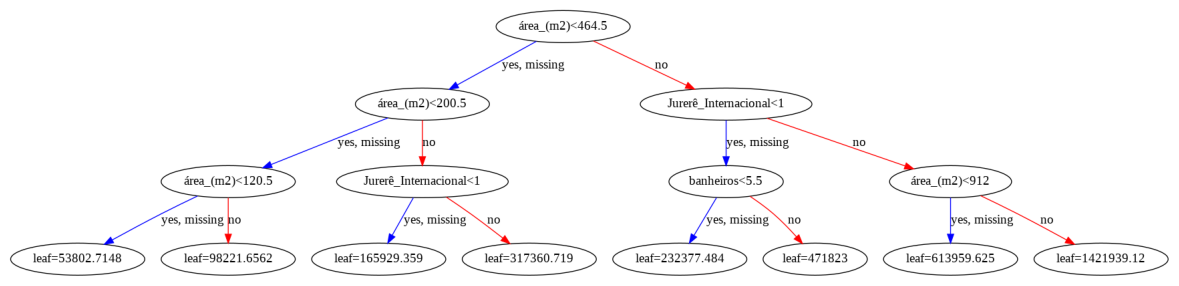

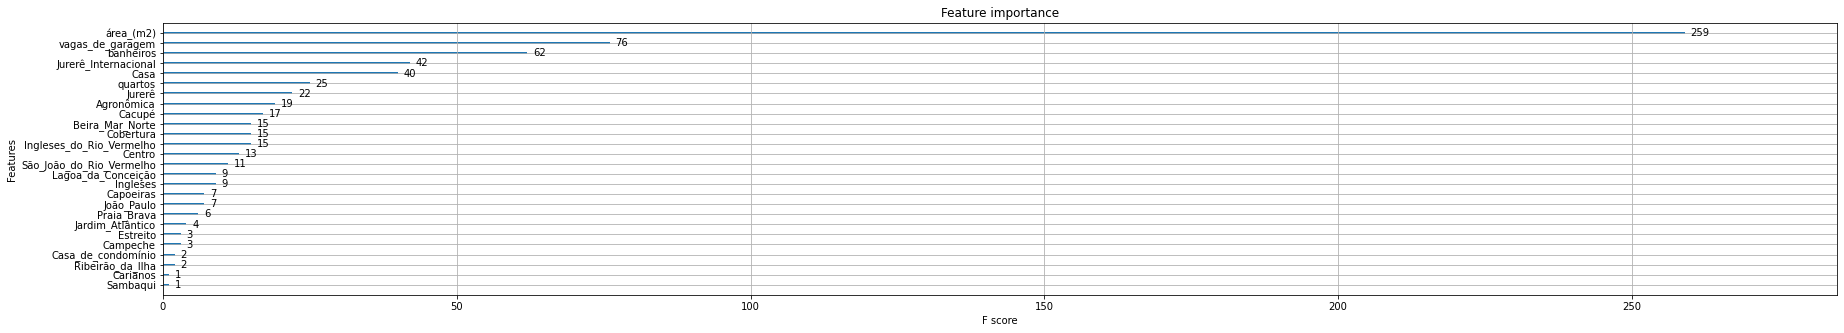

In [ ]:
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 5]

display(plot_tree(model, num_trees=0))
display(plot_importance(model))

In [ ]:
model.save_model('/content/best_model.json')